# PDB 

The module `PDB` defines types and methods to work with protein structures inside Julia. It is useful to link structural and sequential information, and needed for measure the predictive performance at protein contact prediction of mutual information scores. 

## Features  

- [**Read and parse**](#Read-and-parse-PDB-files) PDB and PDBML files  
- Calculate distance and contacts between atoms or residues  
- Determine interaction between residues  

In [1]:
using MIToS.PDB

## Contents

- [Retrieve information from PDB database](#Retrieve-information-from-PDB-database)
- [Read and parse PDB files](#Read-and-parse-PDB-files)
- [Looking for particular residues](#Looking-for-particular-residues)
    - [Getting a Dict of PDBResidues](#Getting-a-Dict-of-PDBResidues)
    - [Select particular residues](#Select-particular-residues)
    - [Select particular atoms](#Select-particular-atoms)
- [Protein contact map](#Protein-contact-map)
- [Structural superposition](#Structural-superposition)

In [2]:
# Truncate IJulia outputs at:
ENV["LINES"]   = 15 
ENV["COLUMNS"] = 60;

<a href="#"><i class="fa fa-arrow-up"></i></a>

## Retrieve information from PDB database

This module exports the `downloadpdb` function, to retrieve a PDB file from  [PDB database<span class="fa fa-external-link" aria-hidden="true"></span>](http://www.rcsb.org/pdb/home/home.do). This function downloads a gzipped PDBML (`"xml"`) file, which could be easily read it with MIToS by default, but you are able to determine the `format` as `"pdb"` if you want it.

In [3]:
pdbfile = downloadpdb("1IVO", format="pdb")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  192k  100  192k    0     0   137k      0  0:00:01  0:00:01 --:--:--  448k


"1IVO.pdb.gz"

`PDB` module also exports a `getpdbdescription` to access the header information of a PDB entry.

In [4]:
getpdbdescription("1IVO")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   2303      0 --:--:-- --:--:-- --:--:--  2298


Dict{AbstractString,AbstractString} with 15 entries:
  "keywords"         => "TRANSFERASE/SIGNALING PROTEIN"
  "citation_authors" => "Ogiso, H., Ishitani, R., Nureki, O…
  "structureId"      => "1IVO"
  "status"           => "CURRENT"
  "release_date"     => "2002-10-16"
  "structure_author… => "Ogiso, H., Ishitani, R., Nureki, O…
  "nr_residues"      => "1350"
  "resolution"       => "3.30"
  "deposition_date"  => "2002-03-28"
  "last_modificatio… => "2011-07-13"
  ⋮                  => ⋮

<a href="#"><i class="fa fa-arrow-up"></i></a>

## Read and parse PDB files

This is easy using the `read` and `parse` functions, indicating the filename and the `Format`: `PDBML` for PDB `"xml"` files or `PDBFile` for usual `"pdb"` files. This functions returns a `Vector` of `PDBResidue` objects with all the residues in the PDB.  
To return only a specific subset of residues/atoms you can use any of the following keyword arguments:  

|keyword arguments | default | returns only ... |
|------------------|---------|-----------|
|`chain` | `"all"` | residues from a PDB chain, i.e. `"A"` |
|`model` | `"all"` | residues from a determined model, i.e. `"1"` |
|`group` | `"all"` | residues from a group: `"ATOM"`, `"HETATM"` or `"all"` for both |
|`atomname` | `"all"` | atoms with a specific name, i.e. `"CA"` |
|`onlyheavy` | `false` | heavy atoms (not hydrogens) if it's `true` |

In [5]:
# Read α carbon of each residue from the 1ivo pdb file, in the model 1, chain A and in the ATOM group.
CA_1ivo = read(pdbfile, PDBFile, model="1", chain="A", group="ATOM", atomname="CA")

CA_1ivo[1] # First residue. It has only the α carbon.

PDBResidue:
	id::PDBResidueIdentifier
		    PDBe_number          number            name           group           model           chain
		             ""             "2"           "GLU"          "ATOM"             "1"             "A"
	atoms::Vector{PDBAtom}	length: 1
		                                                  coordinates            atom         element       occupancy               B
		1:                          Coordinates(92.793,69.578,31.657)            "CA"             "C"             1.0        "151.39"


<a href="#"><i class="fa fa-arrow-up"></i></a>

## Looking for particular residues

MIToS parse PDB files to vector of residues, instead of using a hierarchical structure like other pages. This approach makes the search and selection of residues or atoms a little different. To make it easy, this module exports a number of functions and macros to find, select, collect particular residues or atoms.  
Given the fact that residue numbers from different chains, models, etc. can collide, **it's mandatory to indicate the `model`, `chain`, `group`, `residue` number and `atom` name in a explicit way** to this functions or macros.  
If you want to select all the residues in one of the categories, you are able to use the wildcard `"*"`. You can also use regular expressions or functions to make the selections.

In [6]:
res_1ivo = read(pdbfile, PDBFile)

println("res_1ivo has ", length(res_1ivo), " residues.")

res_1ivo has 1204 residues.


### Getting a `Dict` of `PDBResidue`s

If you prefer a `Dict` of `PDBResidue`, indexed by their residue numbers, you can use the `residuedict` function or the `@residuedict` macro. 


In [7]:
# Dict of residues from the model 1, chain A and from the ATOM group

residuesdict(res_1ivo, "1", "A", "ATOM", "*")

DataStructures.OrderedDict{ASCIIString,MIToS.PDB.PDBResidue} with 511 entries:
  "2"  => PDBResidue:…
  "3"  => PDBResidue:…
  "4"  => PDBResidue:…
  "5"  => PDBResidue:…
  "6"  => PDBResidue:…
  "7"  => PDBResidue:…
  "8"  => PDBResidue:…
  "9"  => PDBResidue:…
  "10" => PDBResidue:…
  "11" => PDBResidue:…
  ⋮    => ⋮

In [8]:
@residuesdict res_1ivo model "1" chain "A" group "ATOM" residue "*"

DataStructures.OrderedDict{ASCIIString,MIToS.PDB.PDBResidue} with 511 entries:
  "2"  => PDBResidue:…
  "3"  => PDBResidue:…
  "4"  => PDBResidue:…
  "5"  => PDBResidue:…
  "6"  => PDBResidue:…
  "7"  => PDBResidue:…
  "8"  => PDBResidue:…
  "9"  => PDBResidue:…
  "10" => PDBResidue:…
  "11" => PDBResidue:…
  ⋮    => ⋮

### Select particular residues

Use the `residues` function to collect specific residues.  
It's possible to use a single **residue number** (i.e. `"2"`), a **list or set** of residue numbers (first example) or even a **function** which should return true for the selected residue numbers (last example). Also **regular expressions** can be used to select residues. Use `"*"` to select all the residues.

In [9]:
residue_list = map(string, 2:5)

# If the list is large, you can use a `Set` to gain performance
# residue_set = Set(map(string, 2:5)) 

4-element Array{ASCIIString,1}:
 "2"
 "3"
 "4"
 "5"

In [10]:
first_res = residues(res_1ivo, "1", "A", "ATOM", reslist)

for res in first_res
    println(res.id.name, " ", res.id.number)
end

LoadError: LoadError: UndefVarError: reslist not defined
while loading In[10], in expression starting on line 1

In [11]:
# Select all the residues of the model 1, chain A of the ATOM group with residue number less than 5

first_res = residues(res_1ivo, "1", "A", "ATOM", x -> parse(Int, match(r"^(\d+)", x)[1]) <= 5 )
# The anonymous function takes the residue number (string) and use a regular expression 
# to extract the number (without insertion code). 
# It converts the number to `Int` to test if the it is `<= 5`.

for res in first_res
    println(res.id.name, " ", res.id.number)
end

GLU 2
GLU 3
LYS 4
LYS 5


Use the `@residues` macro for a cleaner syntax.

In [12]:
# You can use "*", regular expressions, lists, sets or functions also for model, chain and group:

# i.e. Takes the residue 10 from chains A and B

for res in @residues res_1ivo model "1" chain ["A","B"] group "ATOM" residue "10" 
    println(res.id.chain, " ", res.id.name, " ", res.id.number)
end

A THR 10
B THR 10


### Select particular atoms

The `atoms` function or macro allow to select a particular set of …. .

In [13]:
# Select all the atoms with name starting with "C" using a regular expression
# from all the residues of the model 1, chain A of the ATOM group

carbons = @atoms res_1ivo model "1" chain "A" group "ATOM" residue "*" atom r"C.+"

carbons[1]

                                       coordinates            atom         element       occupancy               B
                 Coordinates(92.793,69.578,31.657)            "CA"             "C"             1.0        "151.39"


In [14]:
atoms(res_1ivo, "1", "A", "ATOM", "*", r"C.+")[1]

                                       coordinates            atom         element       occupancy               B
                 Coordinates(92.793,69.578,31.657)            "CA"             "C"             1.0        "151.39"


<a href="#"><i class="fa fa-arrow-up"></i></a>

## Protein contact map

The PDB module offers a number of functions to measure `distance`s between atoms or residues, to detect possible interactions or `contact`s. In particular the `contact` function calls the `distance` function using a threshold or limit. The measure can be done between alpha carbons (`"CA"`), beta carbons (`"CB"`) (alpha carbon for glycine), any heavy atom (`"Heavy"`) or any (`"All"`) atom of the residues.

In the following **example**, whe are going to plot a contact map for the *1ivo* chain A. Two residues will be considered in contact if their β carbons (α carbon for glycine) have a distance of 8Å or less.

In [15]:
pdb = @residues res_1ivo model "1" chain "A" group "ATOM" residue "*"

dmap = distance(pdb, criteria="CB") # Distance between residues

511x511 PairwiseListMatrices.PairwiseListMatrix{Float64,false}:
  0.0       4.77262   7.38393  …  50.9439   56.3445 
  4.77262   0.0       5.81705     46.53     51.8931 
  7.38393   5.81705   0.0         49.0355   54.276  
 11.199     8.12163   5.49485     46.5602   51.6545 
 12.7628    9.14251   6.42569     43.9409   49.0585 
  ⋮                            ⋱             ⋮      
 53.3621   49.0888   51.3456       8.12411   9.2217 
 49.7304   45.4079   47.4174       8.76945  11.5283 
 52.5855   48.1296   50.148        5.59994   6.72689
 50.9439   46.53     49.0355       0.0       5.49568
 56.3445   51.8931   54.276    …   5.49568   0.0    

In [16]:
cmap = contact(pdb, 8.0, criteria="CB") # Contact map

511x511 BitArray{2}:
  true   true   true  false  …  false  false  false
  true   true   true  false     false  false  false
  true   true   true   true     false  false  false
 false  false   true   true     false  false  false
 false  false   true   true     false  false  false
     ⋮                       ⋱                    ⋮
 false  false  false  false      true  false  false
 false  false  false  false      true  false  false
 false  false  false  false      true   true   true
 false  false  false  false      true   true   true
 false  false  false  false  …   true   true   true

In [23]:
using Plots
gr(size=(600,300))

Plots.GRBackend()


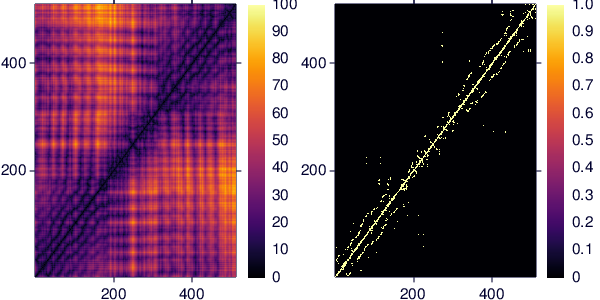

In [24]:
plot(
heatmap(dmap),
heatmap(cmap), 
format=:png, grid=false
)

<a href="#"><i class="fa fa-arrow-up"></i></a>

## Structural superposition

In [19]:
pdbfile = downloadpdb("2HHB")

res_2hhb = read(pdbfile, PDBML)

chain_A = pdb = @residues res_2hhb model "1" chain "A" group "ATOM" residue "*"
chain_C = pdb = @residues res_2hhb model "1" chain "C" group "ATOM" residue "*"

CA_A = CAmatrix(chain_A)
CA_C = CAmatrix(chain_C)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  191k  100  191k    0     0   137k      0  0:00:01  0:00:01 --:--:--  247k


141x3 Array{Float64,2}:
  -7.257  17.813  -4.805
 -10.931  18.37   -4.346
 -12.686  20.107  -7.229
 -15.723  22.283  -6.502
 -17.816  19.436  -7.791
   ⋮                    
  -0.588  11.176   8.609
   1.093  14.519   7.679
   3.187  14.779  10.84 
   4.351  11.214  11.207
   7.906  12.014  10.262

In [20]:
gr(size=(300,300))
scatter3d( CA_A[:,1], CA_A[:,2], CA_A[:,3], label="A", alpha=0.5)
scatter3d!(CA_C[:,1], CA_C[:,2], CA_C[:,3], label="C", alpha=0.5)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<polyline clip-path="url(#clip00)" style="stroke:#000000; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 35.4331,201.258 35.4331,201.258 33.1637,203.313 35.4331,201.258 35.4331,190.053 34.2984,191.081 35.4331,190.053 35.4331,178.849 33.1637,180.904 35.4331,178.849 
 35.4331,167.645 34.2984,168.672 35.4331,167.645 35.4331,156.44 33.1637,158.495 35.4331,156.44 35.4331,145.236 34.2984,146.263 35.4331,145.236 35.4331,134.032 
 33.1637,136.087 35.4331,134.032 35.4331,122.827 34.2984,123.855 35.4331,122.827 35.4331,111.623 33.1637,113.678 35.4331,111.623 
 "/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 A 
 
 
 
 
 
 
 C

In [21]:
superimposed_A, superimposed_C, RMSD = superimpose(chain_A, chain_C)

RMSD

0.23003870483785074

In [22]:
CA_A = CAmatrix(superimposed_A)
CA_C = CAmatrix(superimposed_C)
scatter3d( CA_A[:,1], CA_A[:,2], CA_A[:,3], label="A", alpha=0.5)
scatter3d!(CA_C[:,1], CA_C[:,2], CA_C[:,3], label="C", alpha=0.5)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<polyline clip-path="url(#clip00)" style="stroke:#000000; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 35.4331,201.258 35.4331,201.258 33.1637,203.313 35.4331,201.258 35.4331,190.053 34.2984,191.081 35.4331,190.053 35.4331,178.849 33.1637,180.904 35.4331,178.849 
 35.4331,167.645 34.2984,168.672 35.4331,167.645 35.4331,156.44 33.1637,158.495 35.4331,156.44 35.4331,145.236 34.2984,146.263 35.4331,145.236 35.4331,134.032 
 33.1637,136.087 35.4331,134.032 35.4331,122.827 34.2984,123.855 35.4331,122.827 35.4331,111.623 33.1637,113.678 35.4331,111.623 
 "/>
 
 
 
 
 
 
 
 
 
<polyline clip-path="url(#clip00)" style="stroke:#000000; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 35.4331,201.258 44.2825,205.992 42.0131,208.047 44.2825,205.992 61.9056,215.421 60.7709,216.448 61.9056,215.421 79.5287,224.849 77.2594,226.904 79.5287,224.849 
 97.1518,234.278 96.0172,235.306 97.1518,234.278 114.775,243.707 112.506,245.762 114.775,243.707 132.398,253.135 131.263,254.163 132.398,253.135 150.021,262.564 
 147.752,264.619 150.021,262.564 167.644,271.993 166.51,273.02 167.644,271.993 177.149,277.078 
 "/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 A 
 
 
 
 
 
 
 C